In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import signal

In [457]:
def loaddata(data1, data2):
    img1 = plt.imread(data1)
    img2 = plt.imread(data2)
    
    if len(img1.shape)>2:
        img1 = img1[:,:,1]
        
    if len(img2.shape)>2:
        img2 = img2[:,:,1]
    
    if img1.shape != img2.shape:
        raise ValueError('Dimensions of input images do not match!')
    
    return img1, img2


In [ ]:
img_list = os.listdir('./img')
img_list = [i for i in img_list if ('tif' in i) or ('bmp' in i) or ('TIF' in i)]
img_list.sort()

for i in range(0,len(img_list),2):
    q = loaddata('img/'+img_list[i],'img/'+img_list[i+1])
    print(img_list[i],img_list[i+1],' Size:', q[0].shape)


A001_1.tif A001_2.tif  Size: (1024, 1280)
A045a.tif A045b.tif  Size: (1004, 992)
B005_1.tif B005_2.tif  Size: (512, 512)
B038a.bmp B038b.bmp  Size: (512, 1536)
B_010.TIF B_014.TIF  Size: (688, 1440)
Karman1.tif Karman2.tif  Size: (1584, 2760)


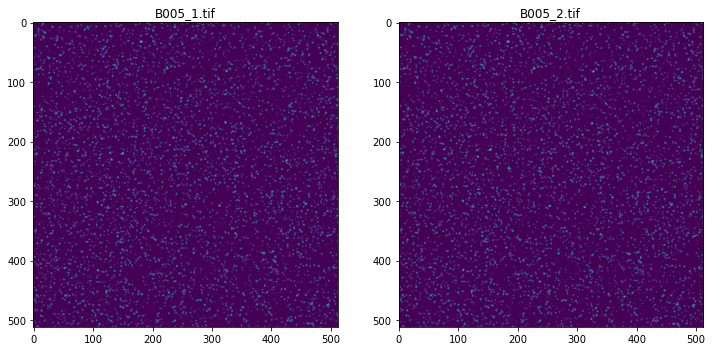

In [460]:

img = loaddata('img/'+img_list[4],'img/'+img_list[5]) 

plt.figure(1,(12,6))

plt.subplot(1,2,1)
plt.imshow(img[0])
plt.title(img_list[4])

plt.subplot(1,2,2)
plt.imshow(img[1])
plt.title(img_list[5])

plt.show()

In [461]:

def velocity_vector(arr1, arr2):
    
    arr1m = [i-np.mean(arr1) for i in arr1]
    arr2m = [i-np.mean(arr2) for i in arr2]
    
    corr = signal.correlate2d(arr1m, arr2m) #'valid'
    
    np.amax(corr)
    ind_max = np.unravel_index(corr.argmax(), corr.shape)
   
    versatz = [(arr1.shape[0]+arr2.shape[0])/2-1, (arr1.shape[1]+arr2.shape[1])/2-1]
        
    v = np.array([versatz[0]-ind_max[1], versatz[1]-ind_max[0]])
    
    if np.amax(v) > arr2.shape[0]/2: #Beschneidung von zu langen Vektoren
        v = arr2.shape[0]/2/np.amax(v)*v
    
    return v


Translationsvektor: [20. 10.]


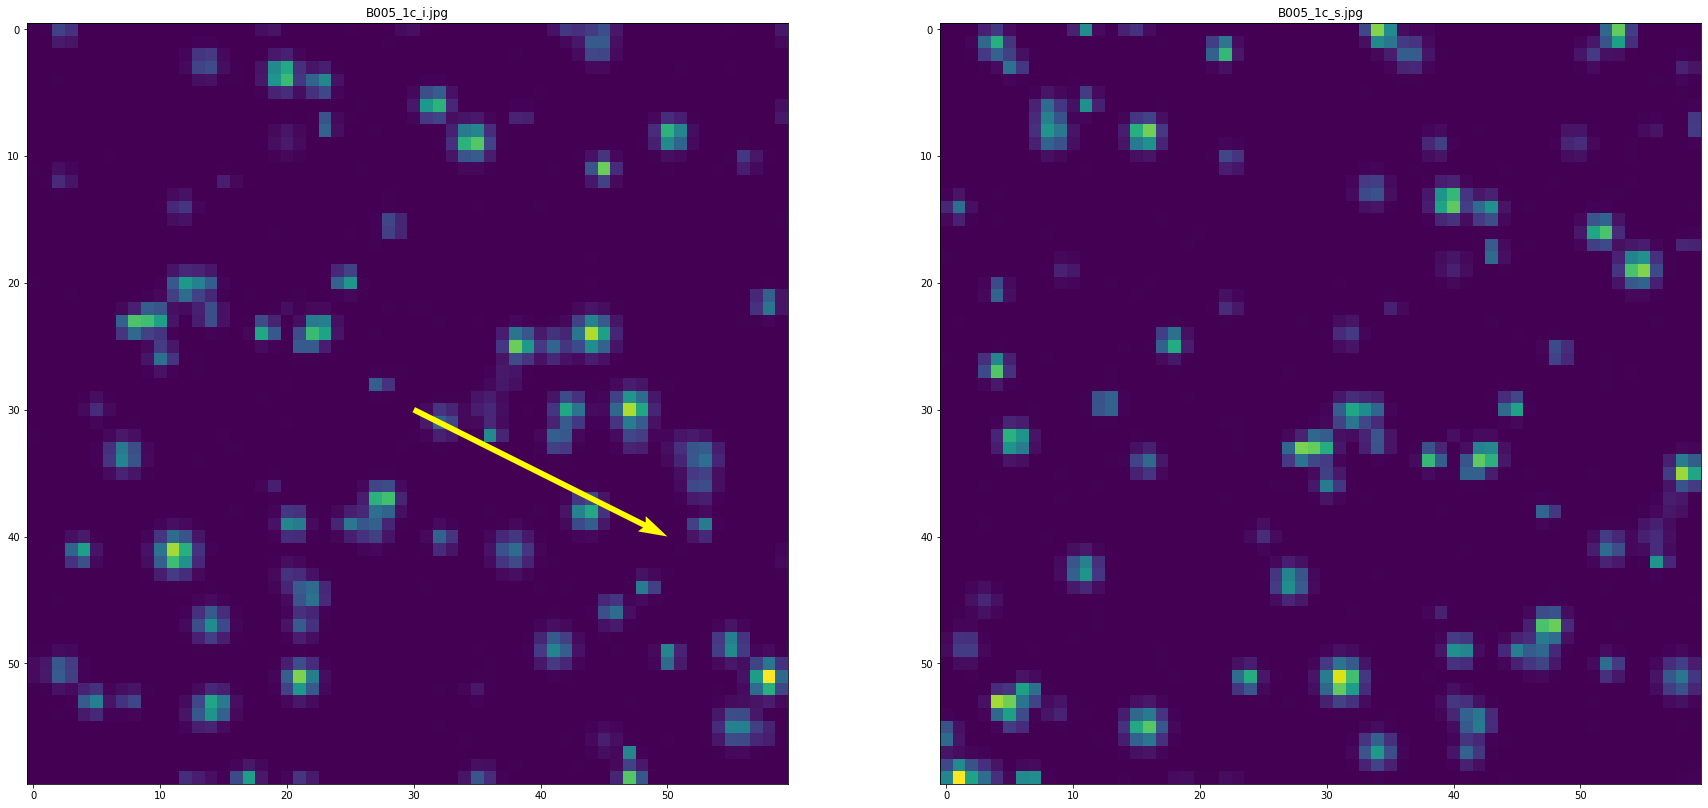

In [463]:

img = loaddata('B005_1c_i.jpg','B005_1c_s.jpg') 

h = velocity_vector(img[0],img[1])

print('Translationsvektor: '+ str(h))

x = img[0].shape[1]/2
y = img[0].shape[0]/2


plt.figure(2,(30,30))

plt.subplot(1,2,1)
plt.imshow(img[0])
plt.quiver(x,y,h[0], -h[1], scale_units='xy', scale=1, color='yellow')
plt.title('B005_1c_i.jpg')
plt.subplot(1,2,2)
plt.imshow(img[1])
plt.title('B005_1c_s.jpg')

plt.show()

In [464]:
def crop(img, i, size, raster): #(Image, Iterator in Raster, Size of Window, Rasterdistanz)
    
    imax = img.shape[1]//raster
    w_cx = raster//2+(i%imax)*raster+1
    w_cy = raster//2+(i//imax)*raster+1
    x00 = int(w_cy-size/2)
    x01 = int(w_cy+size/2)
    x10 = int(w_cx-size/2)
    x11 = int(w_cx+size/2)
    
    while x00 < 0 or x10 < 0 or x01 > img.shape[0] or x11 > img.shape[1]: #kürzen den Fensters auf gültige Imagepixel
        x00 = x00+1
        x01 = x01-1
        x10 = x10+1
        x11 = x11-1
        
    img_cut = img[x00:x01,x10:x11]
    
    return img_cut

In [470]:

def piv(path1, path2, size_iw = 20, size_sw = None, overlap = 0):
    
    
    #Einlesen der Dateien
    img1, img2 = loaddata(path1,path2) 
    
    #Fehlermeldung wenn Suchfenster kleiner als Interrogationsfenster
    if size_sw == None: size_sw = size_iw
    if size_iw%2==1 or size_sw%2==1: raise ValueError("Interrogationsfenster und Suchfenster müssen gerade Anzahl von Pixeln haben")
    if size_sw < size_iw: raise ValueError("Seitenlänge des Suchfensters muss größer gleich dem Interrogationsfenster sein ")
    
    #Auflösung des Vektorfeldes
    r_dist = size_iw-overlap
    res = [img1.shape[0]//r_dist, img1.shape[1]//r_dist] 
    
    #Erstellen des XY-Grid
    x0 = r_dist/2
    x1 = res[1]*r_dist-r_dist/2+1
    y0 = img1.shape[0]-res[0]*r_dist+r_dist/2
    y1 = img1.shape[0]-r_dist/2+1
    X = np.arange(x0,x1,r_dist) 
    Y = np.arange(y0,y1,r_dist)
    X, Y = np.meshgrid(X,Y) 
    

    #Initialisierung der U und V Arrays
    U = np.zeros(res[0]*res[1])
    V = np.zeros(res[0]*res[1])
    
    #Berechnung der Verschiebung
    for i in range(res[0]*res[1]):
        iw = crop(img1, i, size_iw, r_dist)
        sw = crop(img2, i, size_sw, r_dist)
        x = velocity_vector(iw,sw)
        U[i] = x[0]
        V[i] = -x[1]
    
    #Anpassen an XY-Grid und Spiegeln der Y-Achse     
    U = np.flip(np.reshape(U,(res[0],res[1])),axis=0)
    V = np.flip(np.reshape(V,(res[0],res[1])),axis=0)
    
    return X, Y, U, V


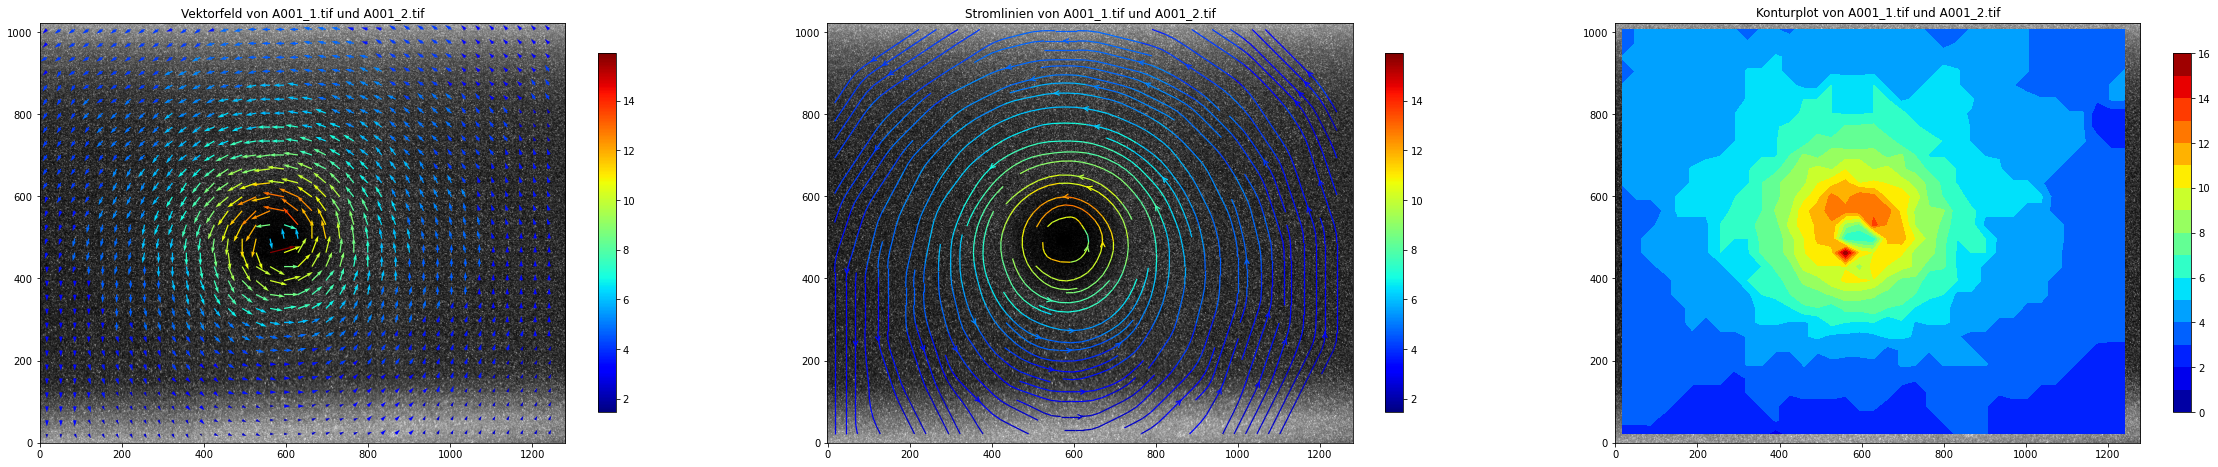

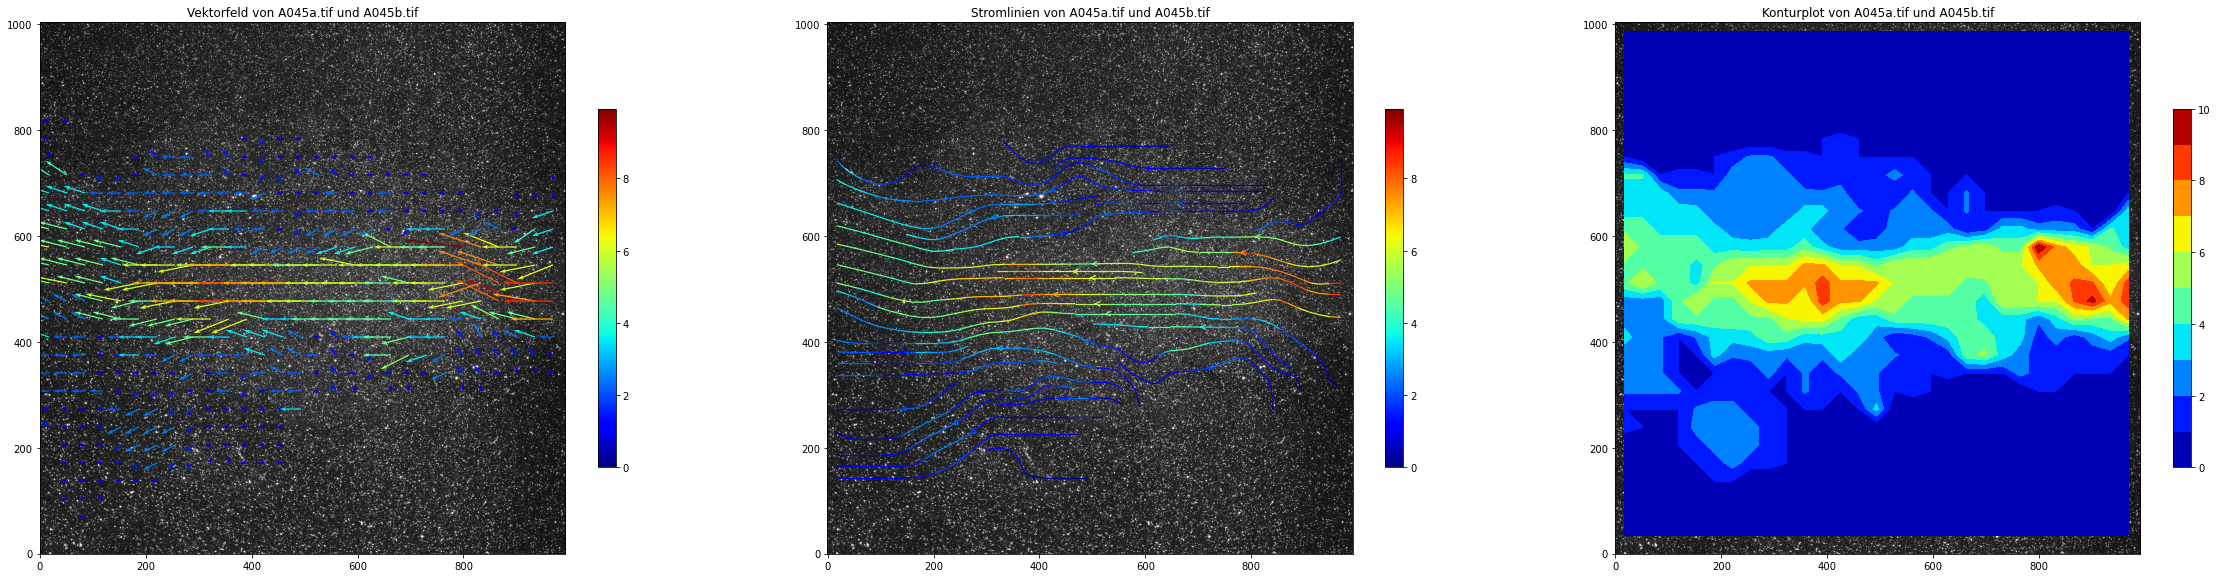

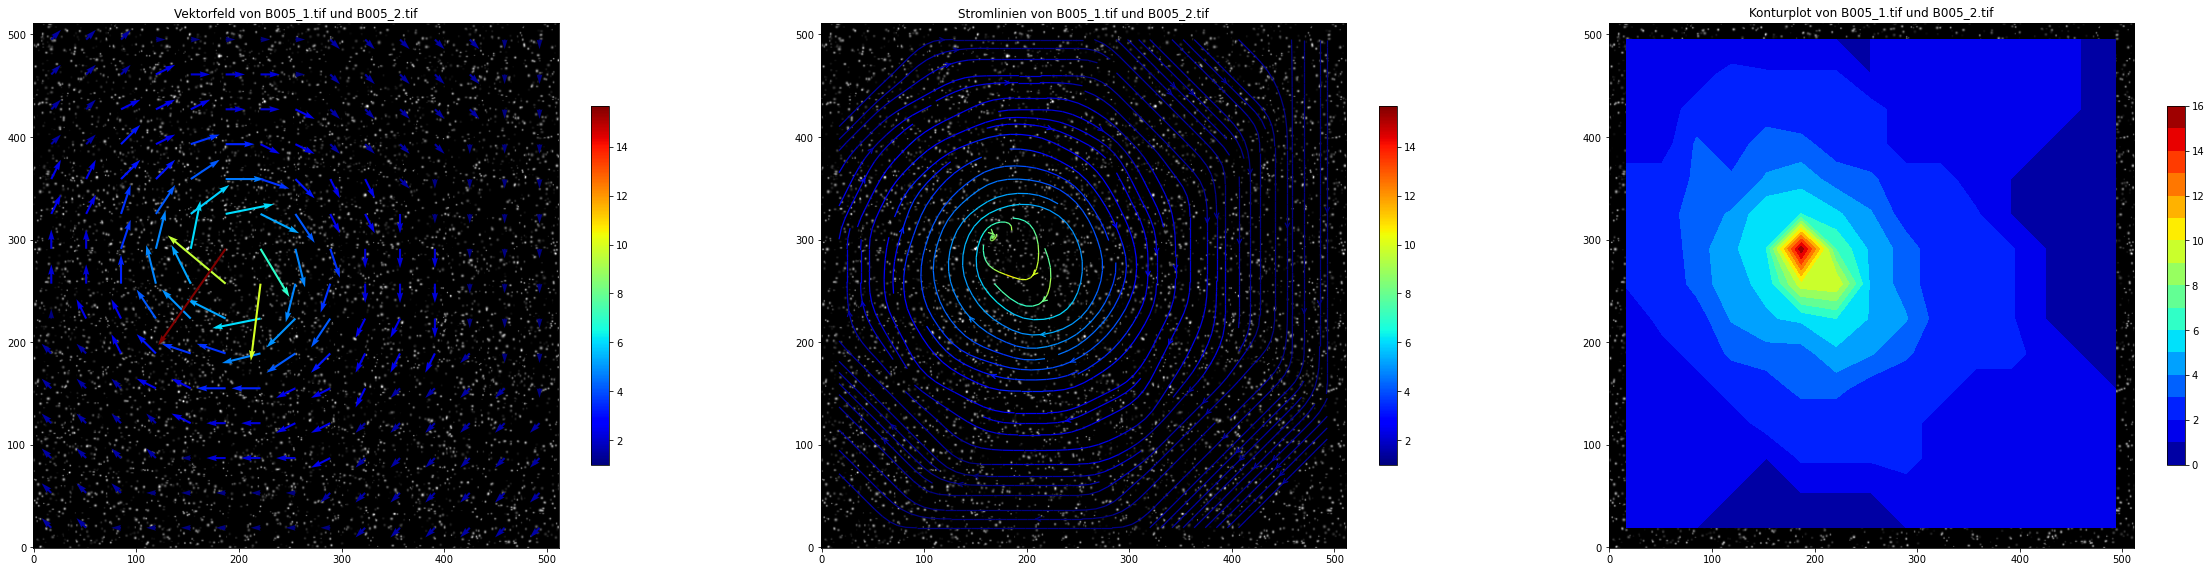

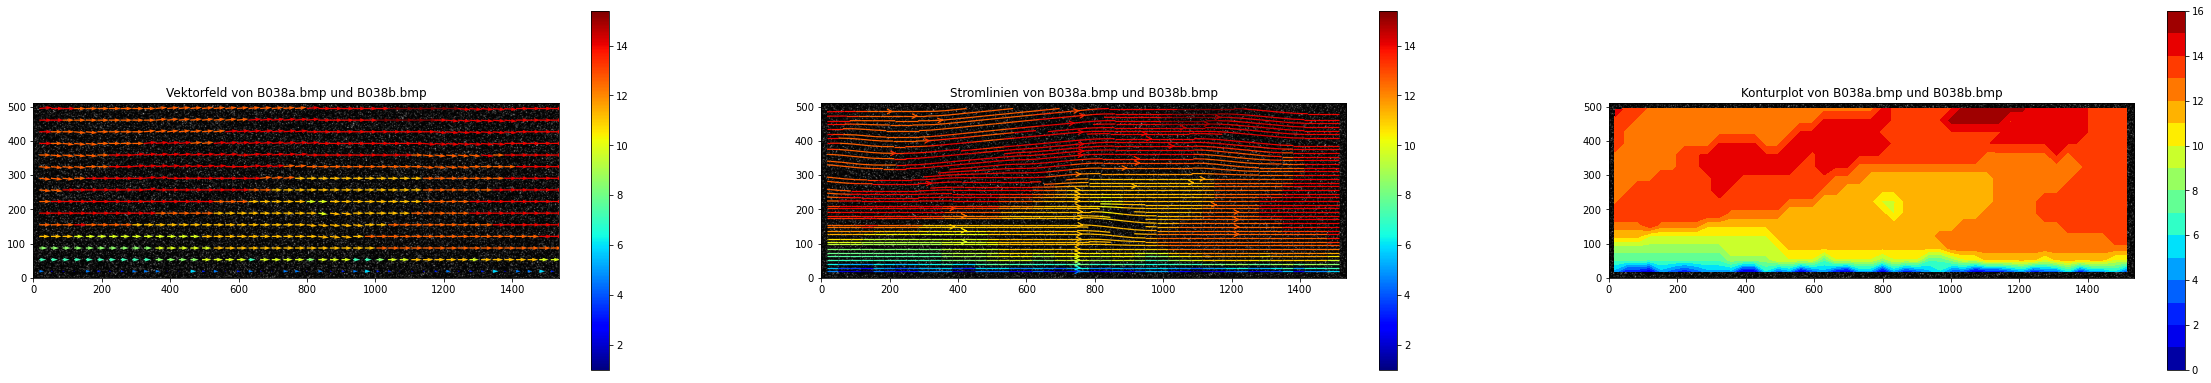

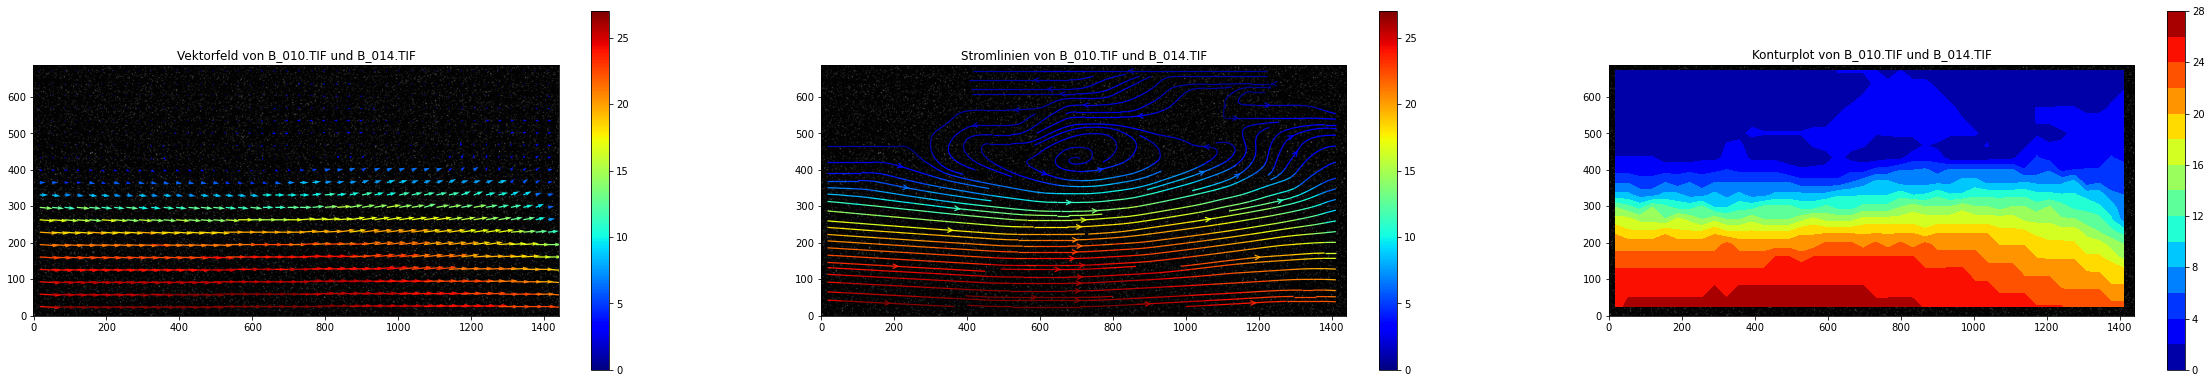

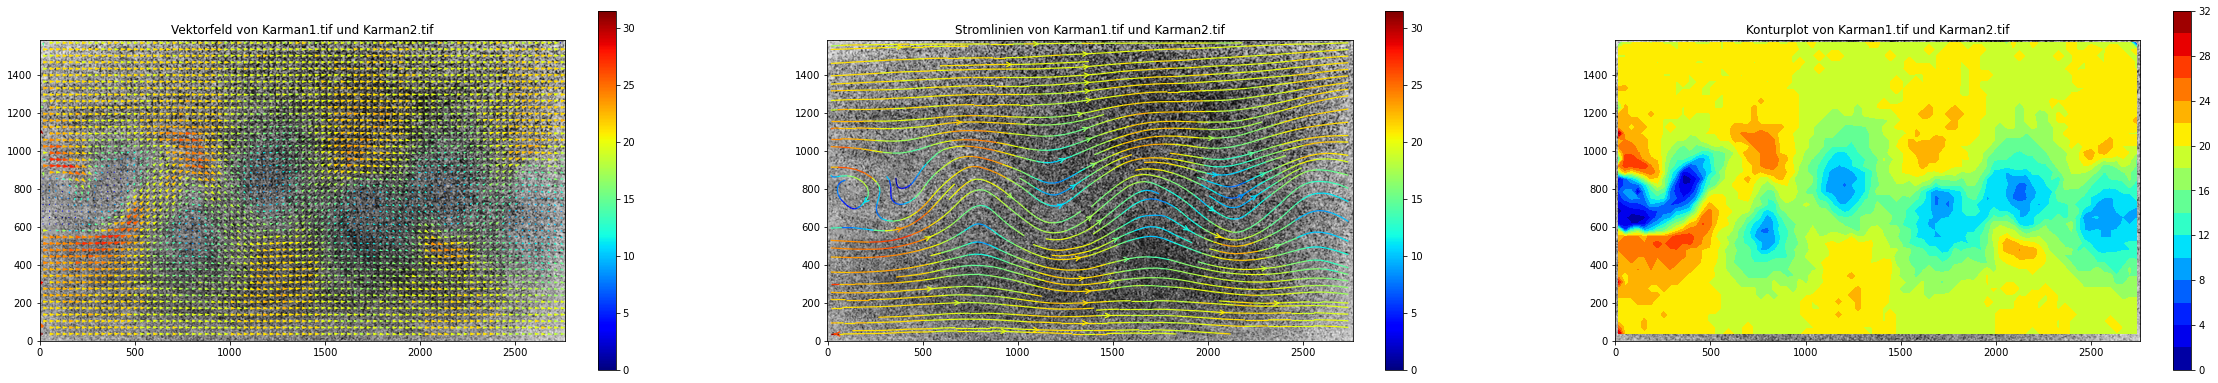

In [473]:

for i in range(0,len(img_list),2):
    
    k = loaddata('img/'+img_list[i],'img/'+img_list[i+1]) #Laden der Bilddaten aus Pfad
    j = np.flip(k[0],axis=0) #spiegeln von Hintergrundbild
    
    a, b, c, d = piv('img/'+img_list[i], 'img/'+img_list[i+1], 50, 60, 16) #PIV Berechnung
    vel_abs = (c**2+d**2)**0.55 #Geschwindigkeitsbetrag
    max_vel = np.amax(vel_abs)

    #Visualisierung in 3 Subplots

    plt.figure(2+i,(40,12))

    plt.subplot(1,3,1)
    plt.quiver(a, b, c, d, [vel_abs], cmap='jet')
    plt.colorbar(shrink=0.55)
    plt.imshow(j, origin='lower', cmap='gray')
    plt.title('Vektorfeld von ' + img_list[i] + ' und ' + img_list[i+1])

    plt.subplot(1,3,2)
    plt.streamplot(a[0],b[:,1],c,d, density=1.5, minlength=0.25, color=vel_abs, cmap='jet', arrowstyle='->', arrowsize=1.1, linewidth=1.25)
    plt.colorbar(shrink=0.55)
    plt.imshow(j, origin='lower', cmap='gray')
    plt.title('Stromlinien von ' + img_list[i] + ' und ' + img_list[i+1])

    plt.subplot(1,3,3)
    plt.contourf(a,b,vel_abs, np.arange(0,max_vel+1,max(max_vel//12,1)), cmap='jet')
    plt.colorbar(shrink=0.55)
    plt.imshow(j, origin='lower', cmap='gray')
    plt.title('Konturplot von ' + img_list[i] + ' und ' + img_list[i+1])

    plt.show()